In [ ]:
pip install numpy networkx matplotlib  scipy pandas

In [ ]:
pip install pulser pulser-simulation

In [ ]:
import numpy as np
import networkx as nx
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize
import pandas as pd

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

**Hydrogenation Model**


Improved CO2 Hydrogenation Optimization
Number of species: 7
Number of reaction pathways: 6

Top 5 Solutions by QUBO Cost:
-----------------------------
1. 1111001 (QUBO Cost: -111.47666666666666)
   Chemical Score: 20
   Pathway Completeness: High
   Selected Species: 0: CO2, 1: HCOO, 2: HCO, 3: CH3O, 6: CH3OH (product)
   Main Pathway Complete: True

2. 1011001 (QUBO Cost: -100.55333333333334)
   Chemical Score: 9
   Pathway Completeness: Low
   Selected Species: 0: CO2, 2: HCO, 3: CH3O, 6: CH3OH (product)
   Main Pathway Complete: False
   Missing Steps: 1: HCOO

3. 1110001 (QUBO Cost: -98.42333333333333)
   Chemical Score: 9
   Pathway Completeness: Low
   Selected Species: 0: CO2, 1: HCOO, 2: HCO, 6: CH3OH (product)
   Main Pathway Complete: False
   Missing Steps: 3: CH3O

4. 1101001 (QUBO Cost: -95.16666666666666)
   Chemical Score: 9
   Pathway Completeness: Low
   Selected Species: 0: CO2, 1: HCOO, 3: CH3O, 6: CH3OH (product)
   Main Pathway Complete: False
   Missing Steps: 

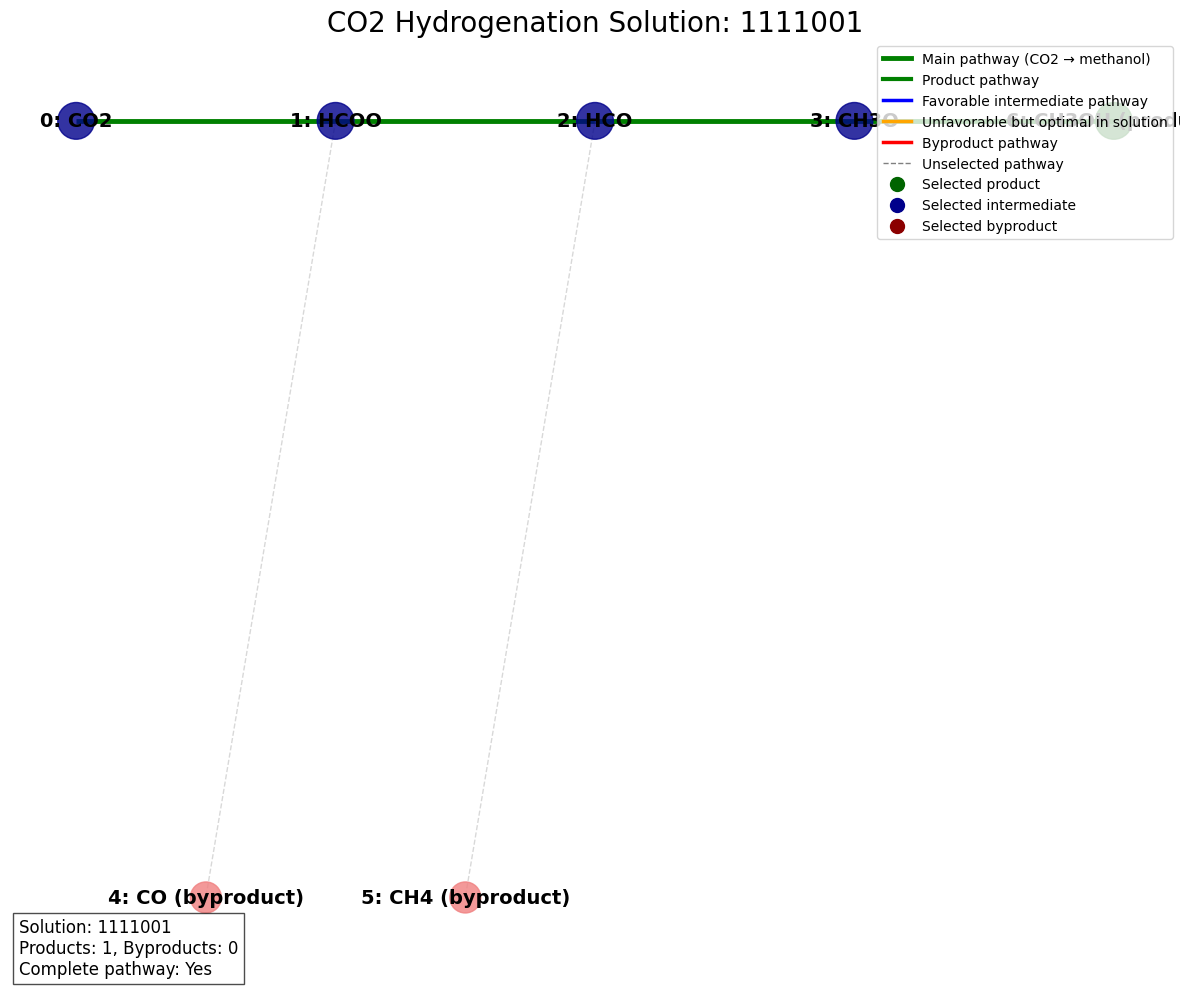

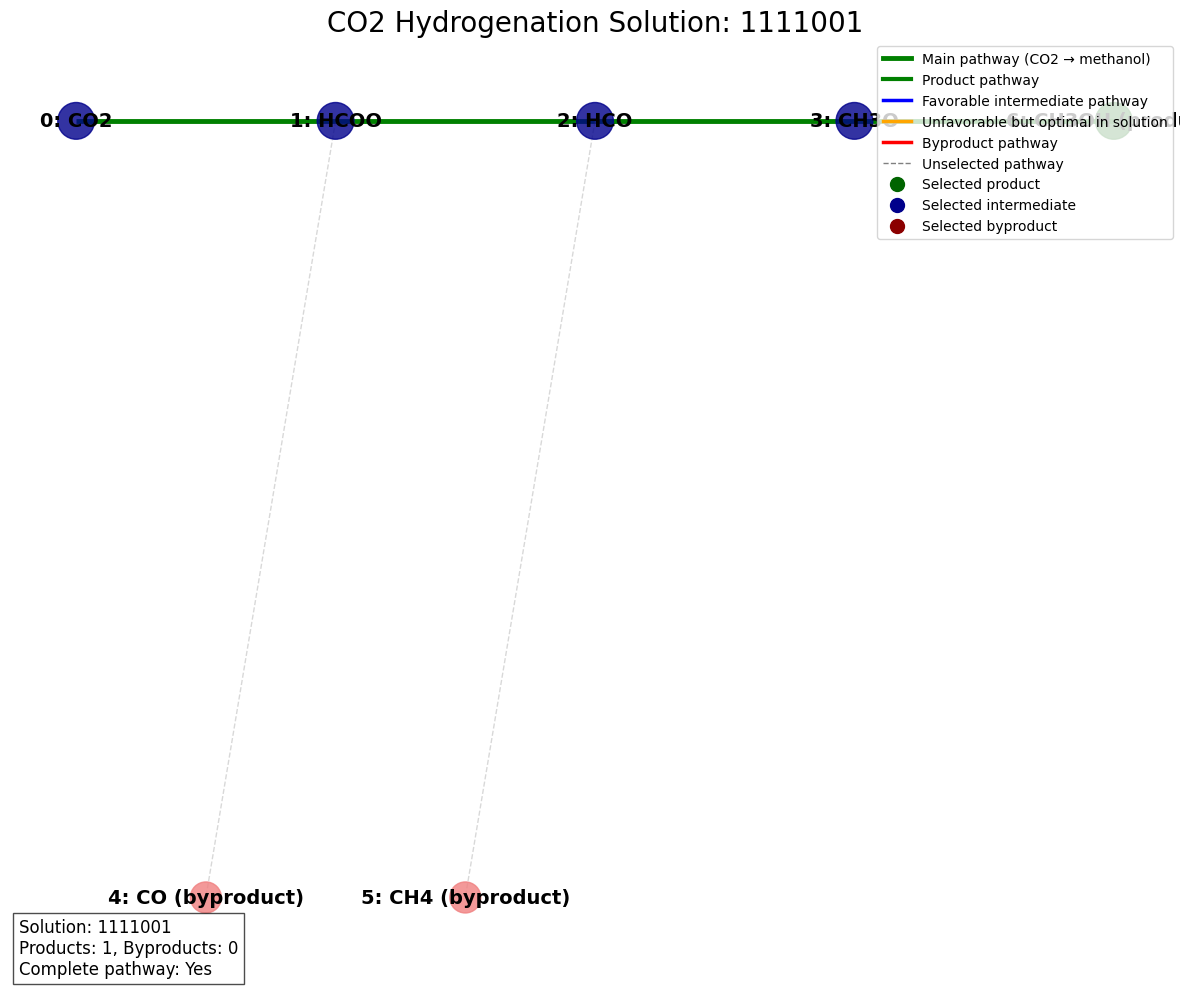

In [ ]:
def lambda_fun(weight, lambda_min=0.3, lambda_max=2):
    """Penalization function for reaction pathways based directly on weights.
        Args:
        weight: (float) Weight value for the pathway
        lambda_min: minimum penalization for favorable pathways
        lambda_max: maximum penalization for unfavorable pathways

        Return:
            lambda_ij: (float) Penalization for the given pathway
    """
    # Invert the relationship: lower weights should give lower lambda values
    # Higher weights should give higher lambda values
    if weight <= 0.01:  # Very low weight (very favorable)
        return lambda_min
    elif weight >= 0.9:  # Very high weight (very unfavorable)
        return lambda_max
    else:
        # Linear interpolation between lambda_min and lambda_max
        normalized_weight = (weight - 0.01) / (0.9 - 0.01)
        lambda_value = lambda_min + normalized_weight * (lambda_max - lambda_min)
        return round(lambda_value, 2)


def visualize_solution(G, solution_bitstring, pos=None, lambda_ij=None, weight_dict=None, Q=None):
    """Visualize a specific solution to the CO2 hydrogenation problem with improved edge coloring.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution
        pos (dict): Optional node positions
        lambda_ij (dict): Dictionary of lambda values for each pathway
        weight_dict (dict): Dictionary of weights for each pathway
        Q (np.array): QUBO matrix used for optimization
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    solution = [int(bit) for bit in solution_bitstring]

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 10))

    # Get node labels
    labels = {}
    for node in G.nodes():
        labels[node] = G.nodes[node].get('name', f"Species_{node}")

    # Determine node colors based on selection and type
    node_colors = []
    for n in G.nodes():
        if solution[n] == 1:  # Selected in solution
            if 'product' in G.nodes[n].get('name', '').lower() and 'byproduct' not in G.nodes[n].get('name', '').lower():
                node_colors.append('darkgreen')  # Selected product - dark green
            elif 'byproduct' in G.nodes[n].get('name', '').lower():
                node_colors.append('darkred')    # Selected byproduct - dark red
            else:
                node_colors.append('darkblue')   # Selected intermediate - dark blue
        else:  # Not selected in solution
            if 'product' in G.nodes[n].get('name', '').lower() and 'byproduct' not in G.nodes[n].get('name', '').lower():
                node_colors.append('lightgreen')  # Unselected product - light green
            elif 'byproduct' in G.nodes[n].get('name', '').lower():
                node_colors.append('lightcoral')  # Unselected byproduct - light red
            else:
                node_colors.append('lightblue')   # Unselected intermediate - light blue

    # Draw nodes with appropriate colors and sizes
    nx.draw_networkx_nodes(G, pos, node_size=[700 if solution[n] == 1 else 500 for n in G.nodes],
                           node_color=node_colors, alpha=0.8)

    # Draw edges with different styles based on whether both end nodes are selected
    selected_edges = [(i, j) for i, j in G.edges() if solution[i] == 1 and solution[j] == 1]
    other_edges = [(i, j) for i, j in G.edges() if (i, j) not in selected_edges]

    # Define main pathway for special coloring
    main_pathway_pairs = [(0,1), (1,2), (2,3), (3,6)]  # CO2 → HCOO → HCO → CH3O → CH3OH

    # Define product and byproduct nodes
    products = []
    byproducts = []
    for i in G.nodes():
        node_name = G.nodes[i].get('name', '')
        if 'product' in node_name.lower() and 'byproduct' not in node_name.lower():
            products.append(i)
        elif 'byproduct' in node_name.lower():
            byproducts.append(i)

    # Draw selected edges with comprehensive coloring scheme
    if selected_edges:
        for u, v in selected_edges:
            # Initialize variables for color decision
            pathway_type = "regular"
            weight = weight_dict.get((u, v), 0.5) if weight_dict else 0.5

            # Check if part of main pathway
            if (u, v) in main_pathway_pairs or (v, u) in main_pathway_pairs:
                pathway_type = "main"

            # Check if pathway leads to product
            elif u in products or v in products:
                pathway_type = "product"

            # Check if pathway leads to byproduct
            elif u in byproducts or v in byproducts:
                pathway_type = "byproduct"

            # Get Q value for this edge if available
            q_value = Q[u, v] if Q is not None else None

            # Decision making for edge color
            if pathway_type == "main":
                # Main pathway gets priority coloring - always positive (green)
                edge_color = 'green'
                edge_style = 'solid'
                width = 3.5
            elif pathway_type == "byproduct":
                # Byproduct pathways always shown as negative (red)
                edge_color = 'red'
                edge_style = 'solid'
                width = 2.5
            elif pathway_type == "product":
                # Product pathways generally positive
                edge_color = 'green'
                edge_style = 'solid'
                width = 3.0
            else:
                # Regular pathways colored by a combination of weight and Q value
                if q_value is not None and q_value < 0:
                    # QUBO encourages this pathway (negative weights are favorable)
                    edge_color = 'blue'
                elif weight < 0.1:
                    edge_color = 'green'  # Favorable path (low weight)
                elif weight > 0.9:
                    edge_color = 'orange'  # Unfavorable but included in solution
                else:
                    edge_color = 'blue'  # Neutral
                edge_style = 'solid'
                width = 2.5

            # Draw the edge with selected properties
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width,
                                  edge_color=edge_color, style=edge_style)

    # Draw other edges (thin, dashed lines)
    nx.draw_networkx_edges(G, pos, edgelist=other_edges, width=1.0,
                          edge_color='gray', style='dashed', alpha=0.3)

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=14, font_weight='bold')

    # Add enhanced legend explaining the coloring scheme
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=3.5, label='Main pathway (CO2 → methanol)'),
        plt.Line2D([0], [0], color='green', lw=3, label='Product pathway'),
        plt.Line2D([0], [0], color='blue', lw=2.5, label='Favorable intermediate pathway'),
        plt.Line2D([0], [0], color='orange', lw=2.5, label='Unfavorable but optimal in solution'),
        plt.Line2D([0], [0], color='red', lw=2.5, label='Byproduct pathway'),
        plt.Line2D([0], [0], color='gray', lw=1, linestyle='dashed', label='Unselected pathway'),
        plt.Line2D([0], [0], marker='o', color='darkgreen', markersize=10, linestyle='', label='Selected product'),
        plt.Line2D([0], [0], marker='o', color='darkblue', markersize=10, linestyle='', label='Selected intermediate'),
        plt.Line2D([0], [0], marker='o', color='darkred', markersize=10, linestyle='', label='Selected byproduct')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Add solution evaluation summary if available
    if weight_dict is not None:
        # Calculate some basic statistics about the solution
        selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]
        product_count = sum(1 for i in selected_nodes if i in products)
        byproduct_count = sum(1 for i in selected_nodes if i in byproducts)

        # Check if main pathway is complete
        main_pathway = [0, 1, 2, 3, 6]  # CO2 → HCO → CH3O → CH3OH
        main_pathway_complete = all(node in selected_nodes for node in main_pathway)

        # Add text annotation with solution summary
        summary_text = f"Solution: {solution_bitstring}\n"
        summary_text += f"Products: {product_count}, Byproducts: {byproduct_count}\n"
        summary_text += f"Complete pathway: {'Yes' if main_pathway_complete else 'No'}"

        plt.figtext(0.02, 0.02, summary_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"CO2 Hydrogenation Solution: {solution_bitstring}", fontsize=20)
    plt.axis('off')
    plt.tight_layout()

    return plt.gcf()


# Create improved CO2 hydrogenation example with updated network structure
def create_improved_co2_hydrogenation_example():
    import networkx as nx
    import numpy as np

    # Define reaction network species with the new sequence from the diagram
    species_names = [
        "CO2",           # 0: starting material
        "HCOO",          # 1: intermediate (changed from CO2)
        "HCO",           # 2: formyl intermediate (changed from HCOO)
        "CH3O",          # 3: methoxy intermediate (moved up in sequence)
        "CO",            # 4: carbon monoxide (undesired byproduct)
        "CH4",           # 5: methane (undesired byproduct)
        "CH3OH"          # 6: methanol (desired product)
    ]
    # Create graph manually for this specific network
    G = nx.Graph()

    # Add nodes with descriptive names and correct node numbers
    for i, name in enumerate(species_names):
        if i == 6:
            G.add_node(i, name=f"{i}: {name} (product)")
        elif i in [4, 5]:
            G.add_node(i, name=f"{i}: {name} (byproduct)")
        else:
            G.add_node(i, name=f"{i}: {name}")



    G.add_edge(0, 1)  # CO2 → HCOO
    G.add_edge(1, 2)  # HCOO → HCO
    G.add_edge(2, 3)  # HCO → CH3O
    G.add_edge(3, 6)  # CH3O → CH3OH

    # Undesired pathways
    G.add_edge(1, 4)  # CO2 → CO (competing reaction)
    G.add_edge(2, 5)  # HCO → CH4 (competing reaction)

    # UPDATED: Weights based on the provided values
    weights = {
        (0, 1): 1.0,
        (1, 2): 0.1,
        (1, 4): 0.997562,
        (2, 3): 0.25,
        (2, 5): 0.75,
        (3, 6): 1.0,
    }

    # Add symmetric values
    for (i, j), value in list(weights.items()):
        weights[(j, i)] = value

    # Calculate lambda values and QUBO matrix using improved function
    lambda_ij, Q = set_improved_problem(G, weights)

    # Visualize the reaction network
    pos = visualize_hydrogenation_network(G, lambda_ij, weights)

    return G, lambda_ij, Q, weights, pos


# Corrected analyze_pathway_completeness function for the new network
def analyze_pathway_completeness(G, solution_bitstring):
    """Analyze whether a solution contains complete reaction pathways from CO2 to products.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution

    Returns:
        dict: Analysis of pathway completeness
    """
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Updated main pathway from CO2 to methanol based on new network
    main_pathway =  [0, 1, 2, 3, 6] # CO2 → HCO → CH3O → CH3OH

    # Check if all nodes in the main pathway are selected
    main_pathway_complete = all(node in selected_nodes for node in main_pathway)

    # Check if all connections in the main pathway are possible
    main_connections_possible = True
    for i in range(len(main_pathway)-1):
        if main_pathway[i] not in selected_nodes or main_pathway[i+1] not in selected_nodes:
            main_connections_possible = False
            break

    # Identify missing steps in the main pathway
    missing_steps = []
    for i in range(len(main_pathway)):
        if main_pathway[i] not in selected_nodes:
            node_name = G.nodes[main_pathway[i]].get('name', f"Species_{main_pathway[i]}")
            missing_steps.append(node_name)

    # Check for byproduct formation pathways
    byproduct_pathways = []
    byproduct_nodes = [4, 5]  # CO, CH4 - Updated node numbers

    for byproduct in byproduct_nodes:
        if byproduct in selected_nodes:
            # Find connections to this byproduct
            for neighbor in G.neighbors(byproduct):
                if neighbor in selected_nodes:
                    source_name = G.nodes[neighbor].get('name', f"Species_{neighbor}")
                    byproduct_name = G.nodes[byproduct].get('name', f"Species_{byproduct}")
                    byproduct_pathways.append(f"{source_name} → {byproduct_name}")

    return {
        "main_pathway_complete": main_pathway_complete,
        "main_connections_possible": main_connections_possible,
        "missing_steps": missing_steps,
        "byproduct_pathways": byproduct_pathways,
        "chemical_feasibility": "High" if main_pathway_complete else
                              "Medium" if main_connections_possible else
                              "Low"
    }


# Updated set_improved_problem function with corrected pathway handling
def set_improved_problem(G, weights, strength=10):
    """Return improved lambda_ij terms and Q matrix for the CO2 hydrogenation problem

    Args:
        G (networkx graph): Graph that represent the reaction network
        weights (dict): Dictionary with weights for each pathway
        strength (float): Amplification of the signal

    Return:
        lambda_ij (dict): keys:(species_1, species_2) Values: lambda values
        Q (np.array): Q matrix of the QUBO.
    """
    import numpy as np

    n_nodes = len(G.nodes)
    Q = np.zeros((n_nodes, n_nodes))
    lambda_ij = {}

    # Identify products and byproducts for differential weighting
    products = []
    byproducts = []
    intermediates = []

    for i in G.nodes():
        node_name = G.nodes[i].get('name', '')
        if 'product' in node_name.lower() and 'byproduct' not in node_name.lower():
            products.append(i)
        elif 'byproduct' in node_name.lower():
            byproducts.append(i)
        else:
            intermediates.append(i)

    # Set diagonal elements to favor products and penalize byproducts
    for i in range(n_nodes):
        if i in products:
            # Strong incentive to include desired products (node 5: CH3OH)
            Q[i, i] = -5 * strength
        elif i in byproducts:
            # Strong penalty for including byproducts (nodes 4: CO, 5: CH4)
            Q[i, i] = 3 * strength
        elif i == 0:  # CO2 (starting material)
            # Incentive to include starting material
            Q[i, i] = -2 * strength
        else:
            # Small incentive for intermediates
            Q[i, i] = -1 * strength

    # Process edges with modified pathway evaluation
    for i, j in G.edges:
        # Get pathway weight with default if not provided
        weight = weights.get((i, j), 0.5)

        # Calculate lambda value based on weight
        lambda_val = lambda_fun(weight)
        lambda_ij[(i, j)] = lambda_val

        # Apply additional pathway weighting logic
        pathway_weight = strength * lambda_val

        # Special handling for pathways leading to products vs byproducts
        if i in products or j in products:
            # Decrease penalties for desired product pathways
            pathway_weight *= 0.5

        if i in byproducts or j in byproducts:
            # Increase penalties for byproduct pathways
            pathway_weight *= 2.0

        # Connectivity bonus for main pathway (CO2 → HCO → CH3O → CH3OH)
        main_pathway_pairs = [(0,1), (1,2), (2,3), (3,6)]  # Updated indices of main pathway steps
        if (i,j) in main_pathway_pairs or (j,i) in main_pathway_pairs:
            # Decrease penalties for main pathway connections
            pathway_weight *= 0.3

        # Populate Q matrix symmetrically
        Q[i, j] = (1/2) * pathway_weight
        Q[j, i] = (1/2) * pathway_weight

    # Add pathway completion incentive - to encourage complete pathways
    # This creates couplings between non-adjacent nodes in the main pathway
    # to incentivize including the complete CO2->methanol pathway
    main_pathway =  [0, 1, 2, 3, 6]  # Updated main pathway

    for idx in range(len(main_pathway)-1):
        for jdx in range(idx+1, len(main_pathway)):
            i, j = main_pathway[idx], main_pathway[jdx]
            # Skip if direct neighbors (already handled above)
            if G.has_edge(i, j):
                continue

            # Add negative coupling to encourage selecting both nodes
            coupling_strength = -0.5 * strength * (1.0/(jdx-idx))  # Weaker for distant nodes
            Q[i, j] += coupling_strength
            Q[j, i] += coupling_strength

    return lambda_ij, Q


# Function to visualize the hydrogenation network (placeholder)
def visualize_hydrogenation_network(G, lambda_ij, weight_dict):
    import networkx as nx

    # Simple positioning function
    pos = nx.spring_layout(G, seed=42)

    # Custom positioning for clearer visualization
    # Manually adjust positions for clearer display
    pos[0] = np.array([-1, 0])     # CO2
    pos[1] = np.array([0, 0])      # HCO0
    pos[2] = np.array([1, 0])      # HCO
    pos[3] = np.array([2, 0])      # CH3O
    pos[6] = np.array([3, 0])      # CH3OH (product)
    pos[4] = np.array([-0.5, -1])  # CO (byproduct)
    pos[5] = np.array([0.5, -1])   # CH4 (byproduct)

    return pos


# Update evaluate_chemical_solution function
def evaluate_chemical_solution(G, lambda_ij, weight_dict, solution_bitstring, cost):
    """Evaluate a solution based on chemical relevance and pathway completeness.

    Args:
        G (networkx.Graph): The reaction network graph
        lambda_ij (dict): Dictionary of lambda values for pathways
        weight_dict (dict): Dictionary of weights for pathways
        solution_bitstring (str): Binary string representing the solution
        cost (float): The calculated cost of the solution

    Returns:
        dict: Comprehensive evaluation of the solution
    """
    # Basic solution analysis
    basic_analysis = analyze_hydrogenation_solution(G, solution_bitstring)

    # Pathway completeness analysis
    pathway_analysis = analyze_pathway_completeness(G, solution_bitstring)

    # Calculate a chemical score (separate from the QUBO cost)
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Points for including products and excluding byproducts
    product_score = 5 if 6 in selected_nodes else 0  # +5 for methanol (node 5)
    byproduct_penalty = sum(2 for bp in [4, 5] if bp in selected_nodes)  # -2 for each byproduct

    # Points for complete pathway
    pathway_score = 10 if pathway_analysis["main_pathway_complete"] else 0

    # Points for each step in the main pathway that is included
    main_pathway =  [0, 1, 2, 3, 6]  # Updated main pathway
    step_score = sum(1 for node in main_pathway if node in selected_nodes)

    # Calculate total chemical score
    chemical_score = product_score + step_score + pathway_score - byproduct_penalty

    # Calculate average weight of included pathways
    active_pathways = basic_analysis["active_pathways"]
    if active_pathways:
        avg_pathway_weight = sum(weight_dict.get((i, j), 0.5) for i, j in active_pathways) / len(active_pathways)
    else:
        avg_pathway_weight = 0

    return {
        "solution_bitstring": solution_bitstring,
        "qubo_cost": cost,
        "chemical_score": chemical_score,
        "pathway_completeness": pathway_analysis["chemical_feasibility"],
        "desired_products": len(basic_analysis["products_included"]),
        "undesired_byproducts": len(basic_analysis["byproducts_included"]),
        "avg_pathway_weight": avg_pathway_weight,
        "main_pathway_complete": pathway_analysis["main_pathway_complete"],
        "byproduct_pathways": pathway_analysis["byproduct_pathways"],
        "missing_steps": pathway_analysis["missing_steps"],
        "selected_species": basic_analysis["selected_species_names"]
    }


# Helper function to analyze hydrogenation solution
def analyze_hydrogenation_solution(G, solution_bitstring):
    """Analyze basic properties of a solution.

    Args:
        G (networkx.Graph): The reaction network graph
        solution_bitstring (str): Binary string representing the solution

    Returns:
        dict: Basic analysis of the solution
    """
    solution = [int(bit) for bit in solution_bitstring]
    selected_nodes = [i for i, bit in enumerate(solution) if bit == 1]

    # Get selected species names
    selected_species_names = []
    for node in selected_nodes:
        selected_species_names.append(G.nodes[node].get('name', f"Species_{node}"))

    # Find active pathways (edges between selected nodes)
    active_pathways = []
    for i, j in G.edges():
        if i in selected_nodes and j in selected_nodes:
            active_pathways.append((i, j))

    # Identify products and byproducts
    products_included = []
    byproducts_included = []
    for node in selected_nodes:
        node_name = G.nodes[node].get('name', '')
        if 'product' in node_name.lower() and 'byproduct' not in node_name.lower():
            products_included.append(node)
        elif 'byproduct' in node_name.lower():
            byproducts_included.append(node)

    return {
        "selected_nodes": selected_nodes,
        "selected_species_names": selected_species_names,
        "active_pathways": active_pathways,
        "products_included": products_included,
        "byproducts_included": byproducts_included
    }


# Brute force solver for finding optimal solutions
def improved_brute_force_solution(G, Q, lambda_ij, weight_dict):
    """Find optimal solutions using brute force with separate chemical evaluation.

    Args:
        G (networkx.Graph): The reaction network graph
        Q (np.array): QUBO matrix
        lambda_ij (dict): Dictionary of lambda values for pathways
        weight_dict (dict): Dictionary of weights for pathways

    Returns:
        list: Top solutions by QUBO cost
        list: Top solutions by chemical score
        float: Minimum cost
        float: Maximum cost
    """
    import numpy as np

    n_nodes = len(G.nodes)
    solutions = []

    # Generate all possible solutions (2^n)
    for i in range(2**n_nodes):
        # Convert integer to binary string of length n_nodes
        bitstring = format(i, f'0{n_nodes}b')

        # Calculate QUBO cost
        x = np.array([int(bit) for bit in bitstring])
        cost = x.T @ Q @ x

        # Comprehensive chemical evaluation
        evaluation = evaluate_chemical_solution(G, lambda_ij, weight_dict, bitstring, cost)

        solutions.append(evaluation)

    # Sort solutions by QUBO cost and chemical score
    solutions_by_qubo = sorted(solutions, key=lambda x: x['qubo_cost'])
    solutions_by_chem = sorted(solutions, key=lambda x: -x['chemical_score'])  # Descending

    # Find min and max cost for normalization
    costs = [sol['qubo_cost'] for sol in solutions]
    cost_min, cost_max = min(costs), max(costs)

    # Return top 5 solutions by each metric
    return solutions_by_qubo[:5], solutions_by_chem[:5], cost_min, cost_max


# Main execution for improved model
if __name__ == "__main__":
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt

    # Create improved CO2 hydrogenation example
    G, lambda_ij, Q, weight_dict, pos = create_improved_co2_hydrogenation_example()

    print("\nImproved CO2 Hydrogenation Optimization")
    print("======================================")
    print(f"Number of species: {len(G.nodes)}")
    print(f"Number of reaction pathways: {len(G.edges)}")

    # Find optimal solutions using brute force with chemical evaluation
    top_qubo_solutions, top_chem_solutions, cost_min, cost_max = improved_brute_force_solution(G, Q, lambda_ij, weight_dict)

    print("\nTop 5 Solutions by QUBO Cost:")
    print("-----------------------------")
    for i, sol in enumerate(top_qubo_solutions):
        print(f"{i+1}. {sol['solution_bitstring']} (QUBO Cost: {sol['qubo_cost']})")
        print(f"   Chemical Score: {sol['chemical_score']}")
        print(f"   Pathway Completeness: {sol['pathway_completeness']}")
        print(f"   Selected Species: {', '.join(sol['selected_species'])}")
        print(f"   Main Pathway Complete: {sol['main_pathway_complete']}")
        if sol['missing_steps']:
            print(f"   Missing Steps: {', '.join(sol['missing_steps'])}")
        if sol['byproduct_pathways']:
            print(f"   Byproduct Pathways: {', '.join(sol['byproduct_pathways'])}")
        print()

    print("\nTop 5 Solutions by Chemical Score:")
    print("---------------------------------")
    for i, sol in enumerate(top_chem_solutions):
        print(f"{i+1}. {sol['solution_bitstring']} (Chemical Score: {sol['chemical_score']})")
        print(f"   QUBO Cost: {sol['qubo_cost']}")
        print(f"   Pathway Completeness: {sol['pathway_completeness']}")
        print(f"   Selected Species: {', '.join(sol['selected_species'])}")
        print(f"   Main Pathway Complete: {sol['main_pathway_complete']}")
        if sol['missing_steps']:
            print(f"   Missing Steps: {', '.join(sol['missing_steps'])}")
        if sol['byproduct_pathways']:
            print(f"   Byproduct Pathways: {', '.join(sol['byproduct_pathways'])}")
        print()

    # Visualize the best solution (by chemical score)
    best_chemical_solution = top_chem_solutions[0]['solution_bitstring']
    print(f"Visualizing best chemical solution: {best_chemical_solution}")
    visualize_solution(G, best_chemical_solution, pos, lambda_ij, weight_dict)

    # Visualize the best QUBO solution for comparison
    best_qubo_solution = top_qubo_solutions[0]['solution_bitstring']

    print(f"Visualizing best QUBO solution: {best_qubo_solution}")
    visualize_solution(G, best_qubo_solution, pos, lambda_ij, weight_dict)

**Finding the neutral atoms' positions and Mapping**

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from pulser.devices import DigitalAnalogDevice

def evaluate_mapping(new_coords, Q, backend=DigitalAnalogDevice):
    """Evaluate how well the set of coordinates represent the matrix Q."""
    shape = Q.shape
    new_coords = new_coords.reshape(len(Q), 2)

    # Ensure all coordinates are within 50 μm of the center
    center = new_coords.mean(axis=0)
    distances_from_center = np.linalg.norm(new_coords - center, axis=1)
    if np.any(distances_from_center > 50):
        return 1e10  # Use a large but finite value instead of np.inf

    # Calculate pairwise distances with careful handling for small values
    distances = pdist(new_coords)
    # Avoid division by zero or very small numbers
    distances = np.maximum(distances, 1e-6)

    # Calculate interaction strengths
    new_Q = squareform(backend.interaction_coeff / (distances ** 6))
    #new_Q = squareform(backend.interaction_coeff / (pdist(new_coords) ** 6 + 1e-6))

    # Limit maximum value to avoid extreme values
    new_Q = np.minimum(new_Q, 1e6)

    cost = 0
    for i in range(shape[0]):
        for j in range(i + 1, shape[0]):
            cost += (Q[i, j] - new_Q[i, j]) ** 2
    return cost

def get_layout(Q, pos, print_output=True, seed=0):
    """Find the best set of coordinates for neutral atoms."""
    np.random.seed(seed)

    # Initial coordinates based on input positions
    x0 = np.array(list(pos.values()))

    # Normalize and center the initial coordinates
    x0 = x0 - x0.mean(axis=0)

    #x0 = np.array(list(pos.values()))
    #x0 = (x0 - x0.mean(axis=0)).flatten()
    # Scale to ensure within device constraints
    scale_factor = 40 / np.max(np.abs(x0))
    x0 *= scale_factor


   # Optimization with modified settings


    res = minimize(
        evaluate_mapping,
        x0.flatten(),
        #x0,
        args=(Q),
        method="L-BFGS-B",
        tol=1e-8,
        options={'disp': None}, # Suppress optimizer output
    )



    # Reshape and validate coordinates
    coords = np.reshape(res.x, (len(Q), 2))

    # Double-check device constraints
    center = coords.mean(axis=0)
    distances_from_center = np.linalg.norm(coords - center, axis=1)

    if print_output:
        print(f"Optimization success: {res.success}")
        print(f"Cost function: {res.fun}")
        print(f"Max distance from center: {distances_from_center.max():.2f} μm")

    return coords

def validate_qubit_layout(coords, max_radius=50):
    """Validate that qubit coordinates are within device constraints."""
    center = coords.mean(axis=0)
    distances_from_center = np.linalg.norm(coords - center, axis=1)

    if np.any(distances_from_center > max_radius):
        raise ValueError(f"Some qubits are more than {max_radius} μm from the center")

    return True



# Example usage in main script
if __name__ == "__main__":
    # Create improved CO2 hydrogenation example
    G, lambda_ij, Q, weights, pos = create_improved_co2_hydrogenation_example()

    # Find the coordinates of the qubits with improved constraint handling
    coords = get_layout(Q, pos, seed=0)

    # Validate the layout
    validate_qubit_layout(coords)

    # Create qubit dictionary
    qubits = dict(enumerate(coords))

    # Create Pulser Register
    reg_8q = Register(qubits)

    # Print qubit coordinates
    print("\nQubit Coordinates:")
    for qubit, coord in qubits.items():
        print(f"Qubit {qubit}: {coord}")


Optimization success: True
Cost function: 26.156108463099045
Max distance from center: 35.59 μm

Qubit Coordinates:
Qubit 0: [-29.14569772   8.27178546]
Qubit 1: [-22.94456314  -0.8597404 ]
Qubit 2: [ 8.19003989 -0.88986522]
Qubit 3: [23.1676343   2.64322177]
Qubit 4: [-18.47717052  -7.54974214]
Qubit 5: [ 4.16962206 -7.85761131]
Qubit 6: [35.03719686  6.22529056]


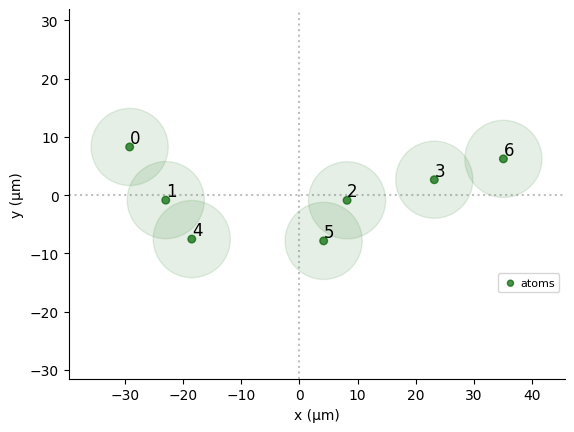

In [ ]:
from pulser.devices import DigitalAnalogDevice
fig, ax = plt.subplots()
reg_8q.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
    custom_ax = ax
)

**QAOA Mapping**

In [ ]:
from pulser.waveforms import ConstantWaveform, RampWaveform

import numpy as np

def run_algorithm(assigned_seq, n_samples=1000, seed=123):
    """Run the circuit simulating the evolution of the neutral atoms' device.

    Args:
        assigned_seq (pulser.Sequence): Sequence of the quantum algorithm, e.g., QAA or QAOA.
        n_samples (int): Number of samples to get.
        seed (int): Seed to see reproducible results.

    Return:
        count_dict (dict): Samples returned by the algorithm, keys: strings values: counts.
    """
    np.random.seed(seed)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state(N_samples=n_samples)  # Sample from the state vector
    return count_dict

def get_cost_QUBO(bitstring, Q):
    """Evaluate the cost function."""
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def mean_cost(counter, Q):
    """Mean value of the cost for some samples."""
    cost = sum(counter[key] * get_cost_QUBO(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

def approximation_ratio(counter, Q, min_energy, max_energy):
    """Approximation ratio."""
    mean_energy = mean_cost(counter, Q)
    r = (mean_energy - max_energy) / (min_energy - max_energy)
    return r


def QAOA(betas, gammas, reg, pulse_width=52, Omega_max=15.0, delta_max=20.0,
                 ramp_time=5, backend=DigitalAnalogDevice):
    """Quantum Approximate Optimization Algorithm.

    Args:
        betas (list): Parameters of the mixer Hamiltonian.
        gammas (list): Parameters of the problem Hamiltonian.
        pulse_width (int): Duration of the betas and the gammas pulses in [ns].
        Omega_max (float): Amplitude of the Rabi frequency in [rad/us].
        delta_max (float): Amplitude of the driving laser [rad/us].

    Return:
        assigned_seq (pulser.Sequence): QAOA sequence.
    """
    LAYERS = len(betas)  # Number p of the QAOA algorithm

    if len(gammas) != LAYERS:
        raise ValueError("betas and gammas have different size.")

    # Parametrized sequence
    seq = Sequence(reg, backend)
    ch0 = seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)

    # Initial state preparation - π/2 pulse to create superposition
    initial_omega_wf = ConstantWaveform(pulse_width//2, Omega_max/2)
    initial_delta_wf = ConstantWaveform(pulse_width//2, 0.0)

    # Create a pulse with the waveforms
    from pulser.pulse import Pulse
    initial_pulse = Pulse(initial_omega_wf, initial_delta_wf, 0)
    seq.add(initial_pulse, "ch0")

    for t, s in zip(t_list, s_list):
        # Problem Hamiltonian
        problem_omega_wf = ConstantWaveform(pulse_width, 0.0)

        # For the problem Hamiltonian, we need a constant detuning
        if ramp_time > 0 and ramp_time < pulse_width/2:
            # With ramping
            try:
                from pulser.waveforms import CompositeWaveform
                ramp_up = RampWaveform(ramp_time, 0.0, delta_max * s)
                middle = ConstantWaveform(pulse_width - 2*ramp_time, delta_max * s)
                ramp_down = RampWaveform(ramp_time, delta_max * s, 0.0)
                problem_delta_wf = CompositeWaveform(ramp_up, middle, ramp_down)
            except ImportError:
                # Fallback to constant if composite not available
                problem_delta_wf = ConstantWaveform(pulse_width, delta_max * s)
        else:
            # No ramping
            problem_delta_wf = ConstantWaveform(pulse_width, delta_max * s)

        problem_pulse = Pulse(problem_omega_wf, problem_delta_wf, 0)
        seq.add(problem_pulse, "ch0")

        # Mixer Hamiltonian
        mixer_delta_wf = ConstantWaveform(pulse_width, 0.0)

        if ramp_time > 0 and ramp_time < pulse_width/2:
            # With ramping
            try:
                from pulser.waveforms import CompositeWaveform
                ramp_up = RampWaveform(ramp_time, 0.0, Omega_max * t)
                middle = ConstantWaveform(pulse_width - 2*ramp_time, Omega_max * t)
                ramp_down = RampWaveform(ramp_time, Omega_max * t, 0.0)
                mixer_omega_wf = CompositeWaveform(ramp_up, middle, ramp_down)
            except ImportError:
                # Fallback to constant if composite not available
                mixer_omega_wf = ConstantWaveform(pulse_width, Omega_max * t)
        else:
            # No ramping
            mixer_omega_wf = ConstantWaveform(pulse_width, Omega_max * t)

        mixer_pulse = Pulse(mixer_omega_wf, mixer_delta_wf, 0)
        seq.add(mixer_pulse, "ch0")

    seq.measure("ground-rydberg")

    guess = {
        "t": [round(i, 5) for i in betas],
        "s": [round(i, 5) for i in gammas],
    }
    parameters = np.r_[guess["t"], guess["s"]]
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(float), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    return assigned_seq


best_betas = [0.05519013445961409,
 0.5025500764489291,
 0.7687742552075342,
 0.744242259489458,
 0.38460759149661505,
 0.06479410819726242,
 0.5231175921543114,
 0.5656520254584226,
 0.5869648725405,
 0.29838198416285416]

best_gammas = [0.09291371525108409,
 1.0092881835892435,
 0.9099666162703384,
 0.42683444674630727,
 0.2081464649951845,
 0.16154146935115238,
 0.569030217250344,
 0.8081530600390686,
 0.9034267416582569,
 0.8065109667608715]

# Assuming 'reg_8q' and 'Q' are defined in your context
qaoa_seq = QAOA(best_betas, best_gammas, reg_8q)  # Sequence with the pulses of QAOA
sol_8q_qaoa = run_algorithm(qaoa_seq, n_samples=1000)  # Sampling the final state of the qaoa_seq

/usr/local/lib/python3.11/dist-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration of 26 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 28 ns.
  self._add(pulse, channel, protocol)


In [ ]:
sols_brute = [sol['solution_bitstring'] for sol in top_chem_solutions]

# Print out the top solutions from QUBO sampling
print("Top QAOA solutions:")
sorted_qubo_solutions = sorted(sol_8q_qaoa.items(), key=lambda x: x[1], reverse=True)
for bitstring, count in sorted_qubo_solutions[:5]:
    cost = get_cost_QUBO(bitstring, Q)
    print(f"Bitstring: {bitstring}, Count: {count}, Cost: {cost}")

print("\nBrute Force solutions:")
if 'sols_brute' in locals():
    for sol in sols_brute:
        cost = get_cost_QUBO(sol, Q)
        count = sol_8q_qaoa.get(sol, 0)
        print(f"Bitstring: {sol}, Cost: {cost}")

Top QAOA solutions:
Bitstring: 1101011, Count: 179, Cost: -65.16666666666666
Bitstring: 1111001, Count: 146, Cost: -113.36666666666667
Bitstring: 1001111, Count: 141, Cost: -22.833333333333336
Bitstring: 1011101, Count: 139, Cost: -71.93333333333334
Bitstring: 1101001, Count: 81, Cost: -95.16666666666666

Brute Force solutions:
Bitstring: 1111001, Cost: -113.36666666666667
Bitstring: 1111011, Cost: -43.36666666666667
Bitstring: 1111101, Cost: -43.36666666666667
Bitstring: 1111111, Cost: 26.633333333333333
Bitstring: 0111001, Cost: -88.53333333333333


In [ ]:
# For top QAOA solutions
print("Top QAOA solutions (with interpretation):")
sorted_qubo_solutions = sorted(sol_8q_qaoa.items(), key=lambda x: x[1], reverse=True)
for bitstring, count in sorted_qubo_solutions[:3]:
    cost = get_cost_QUBO(bitstring, Q)
    print(f"Bitstring: {bitstring}, Count: {count}, Cost: {cost}")

    # Interpret what each QAOA solution means
    selected_nodes = [i for i, bit in enumerate(bitstring) if bit == '1']
    selected_species = []

    # Species names from your CO2 hydrogenation network
    species_names = [
        "CO2",           # 0: starting material
        "HCOO",          # 1: intermediate
        "HCO",           # 2: formyl intermediate
        "CH3O",          # 3: methoxy intermediate
        "CO",            # 4: carbon monoxide (undesired byproduct)
        "CH4",           # 5: methane (undesired byproduct)
        "CH3OH"          # 6: methanol (desired product)
    ]

    # Describe selected species
    for i in selected_nodes:
        if i == 6:
            selected_species.append(f"{i}: {species_names[i]} (product)")
        elif i in [4, 5]:
            selected_species.append(f"{i}: {species_names[i]} (byproduct)")
        else:
            selected_species.append(f"{i}: {species_names[i]}")

    # Print interpretation
    print(f"  Selected species: {', '.join(selected_species)}")

    # Check main pathway completeness
    main_pathway = [0, 1, 2, 3, 6]  # CO2 → HCOO → HCO → CH3O → CH3OH
    main_pathway_complete = all(node in selected_nodes for node in main_pathway)
    print(f"  Complete pathway from CO2 to methanol: {'Yes' if main_pathway_complete else 'No'}")

    # Check for byproducts
    byproducts = [i for i in selected_nodes if i in [4, 5]]
    if byproducts:
        byproduct_names = [f"{i}: {species_names[i]}" for i in byproducts]
        print(f"  Includes undesired byproducts: {', '.join(byproduct_names)}")
    else:
        print("  No undesired byproducts included")

    # Check for missing steps if pathway incomplete
    if not main_pathway_complete:
        missing = [i for i in main_pathway if i not in selected_nodes]
        missing_names = [f"{i}: {species_names[i]}" for i in missing]
        print(f"  Missing from main pathway: {', '.join(missing_names)}")

    print()

# For Brute Force solutions
print("\nBrute Force solutions (with interpretation):")
if 'sols_brute' in locals():
    for sol in sols_brute[:3]:
        cost = get_cost_QUBO(sol, Q)
        count = sol_8q_qaoa.get(sol, 0)
        print(f"Bitstring: {sol}, Cost: {cost}, Count in QAOA: {count}")

        # Interpret what each brute force solution means
        selected_nodes = [i for i, bit in enumerate(sol) if bit == '1']
        selected_species = []

        # Describe selected species
        for i in selected_nodes:
            if i == 6:
                selected_species.append(f"{i}: {species_names[i]} (product)")
            elif i in [4, 5]:
                selected_species.append(f"{i}: {species_names[i]} (byproduct)")
            else:
                selected_species.append(f"{i}: {species_names[i]}")

        # Print interpretation
        print(f"  Selected species: {', '.join(selected_species)}")

        # Check main pathway completeness
        main_pathway_complete = all(node in selected_nodes for node in main_pathway)
        print(f"  Complete pathway from CO2 to methanol: {'Yes' if main_pathway_complete else 'No'}")

        # Check for byproducts
        byproducts = [i for i in selected_nodes if i in [4, 5]]
        if byproducts:
            byproduct_names = [f"{i}: {species_names[i]}" for i in byproducts]
            print(f"  Includes undesired byproducts: {', '.join(byproduct_names)}")
        else:
            print("  No undesired byproducts included")

        # Check for missing steps if pathway incomplete
        if not main_pathway_complete:
            missing = [i for i in main_pathway if i not in selected_nodes]
            missing_names = [f"{i}: {species_names[i]}" for i in missing]
            print(f"  Missing from main pathway: {', '.join(missing_names)}")

        print()

Top QAOA solutions (with interpretation):
Bitstring: 1101011, Count: 179, Cost: -65.16666666666666
  Selected species: 0: CO2, 1: HCOO, 3: CH3O, 5: CH4 (byproduct), 6: CH3OH (product)
  Complete pathway from CO2 to methanol: No
  Includes undesired byproducts: 5: CH4
  Missing from main pathway: 2: HCO

Bitstring: 1111001, Count: 146, Cost: -113.36666666666667
  Selected species: 0: CO2, 1: HCOO, 2: HCO, 3: CH3O, 6: CH3OH (product)
  Complete pathway from CO2 to methanol: Yes
  No undesired byproducts included

Bitstring: 1001111, Count: 141, Cost: -22.833333333333336
  Selected species: 0: CO2, 3: CH3O, 4: CO (byproduct), 5: CH4 (byproduct), 6: CH3OH (product)
  Complete pathway from CO2 to methanol: No
  Includes undesired byproducts: 4: CO, 5: CH4
  Missing from main pathway: 1: HCOO, 2: HCO


Brute Force solutions (with interpretation):
Bitstring: 1111001, Cost: -113.36666666666667, Count in QAOA: 146
  Selected species: 0: CO2, 1: HCOO, 2: HCO, 3: CH3O, 6: CH3OH (product)
  Comple

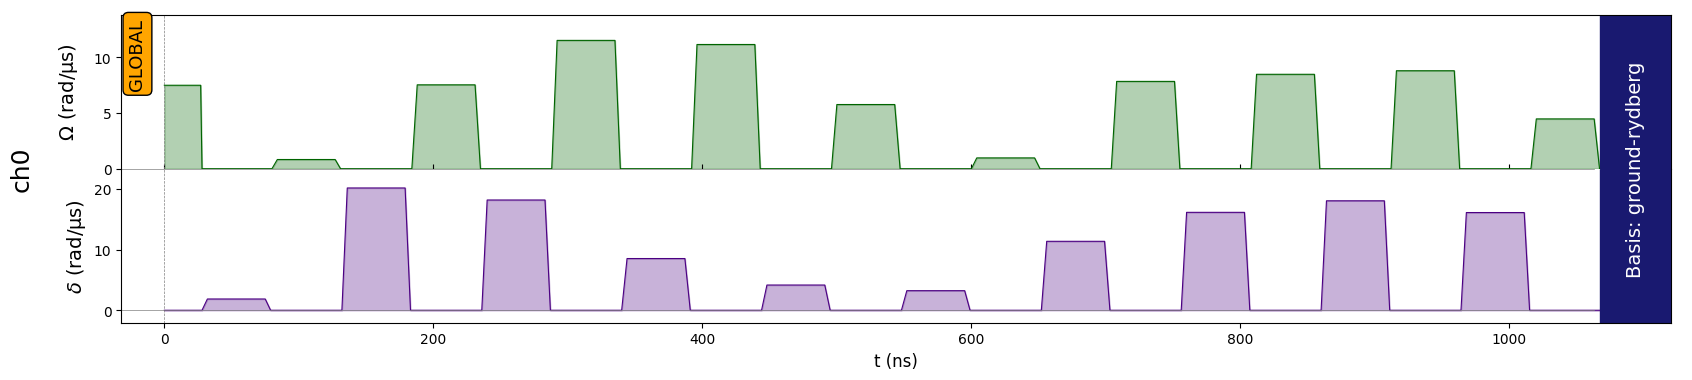

In [ ]:
qaoa_seq.draw(kwargs_savefig={"bbox_inches":"tight"})

**Visualization of the final state probability distribution**

***QAOA achieved an approximation ratio of 0.804, finding solutions that are 80.4% of the way from worst to optimal***

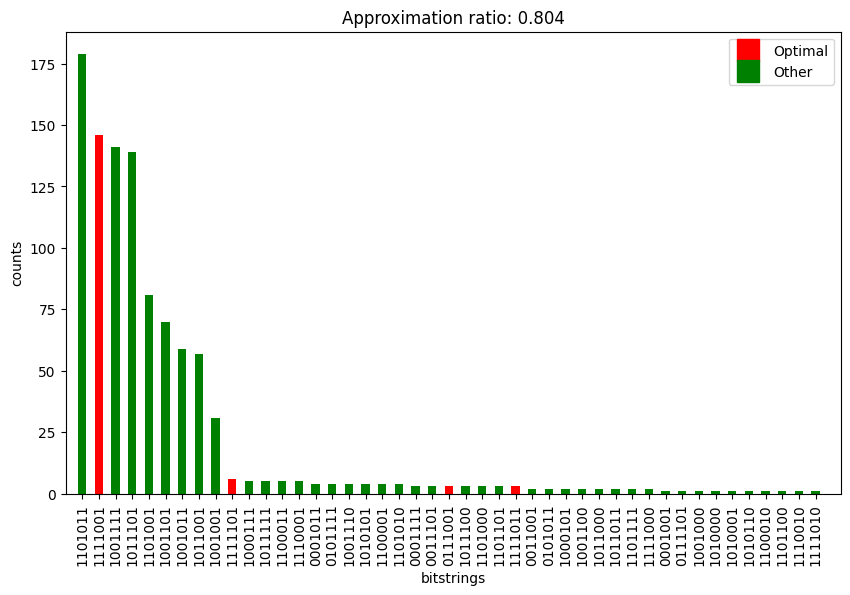

In [ ]:
def plot_distribution(C, sols, ax):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in sols else "g" for key in C}
    ax.set_xlabel("bitstrings")
    ax.set_ylabel("counts")
    ax.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical", fontsize=10)


fig, ax = plt.subplots(figsize=(10, 6))
r = approximation_ratio(sol_8q_qaoa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();
#fig.savefig("./Figures/hist_qaoa_q8.png", bbox_inches="tight")



**QAA Mapping**

In [ ]:
def QAA(Omega, reg, delta_0 = -5, delta_f=5, T=4000, backend=DigitalAnalogDevice):
    """ Quantum Adiabatic Algorithm

        Args:

        Omega (float): Maximum amplitude of the Raby frequency in [rad/us]
        reg (pulser.Register): Pulser register with the information of the atoms
        delta_0 (float): Minimum detuning of the protocol [rad/us]
        delta_f (float): Maximum detuning of the protocol [rad/us]
        T (int): time of the annealing protocol in [ns]

        Return:
        Sed (pulser.Sequence): sequence with the annealing evolution.

    """
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq = Sequence(reg, backend)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    return seq


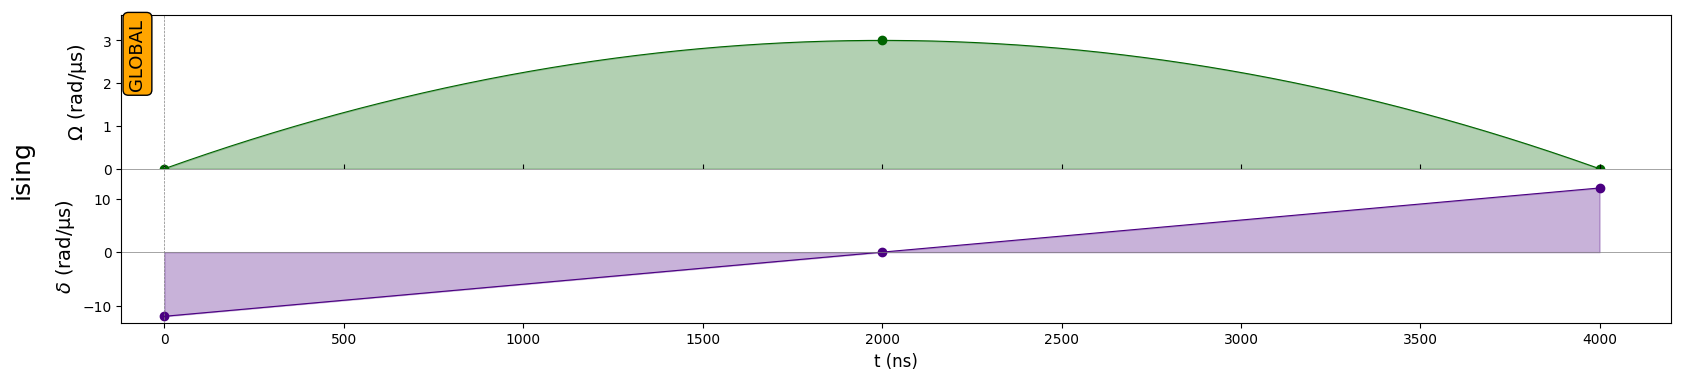

In [ ]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())

delta_0 = - 12  # just has to be negative
delta_f = - delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

seq_qaa = QAA(Omega, reg_8q, delta_0, delta_f, T)
seq_qaa.draw(kwargs_savefig={"bbox_inches":"tight"})


**Visualization of the final state probability distribution**

**QAA achieved an approximation ratio of 0.73, finding solutions that are 73.% of the way from worst to optimal**

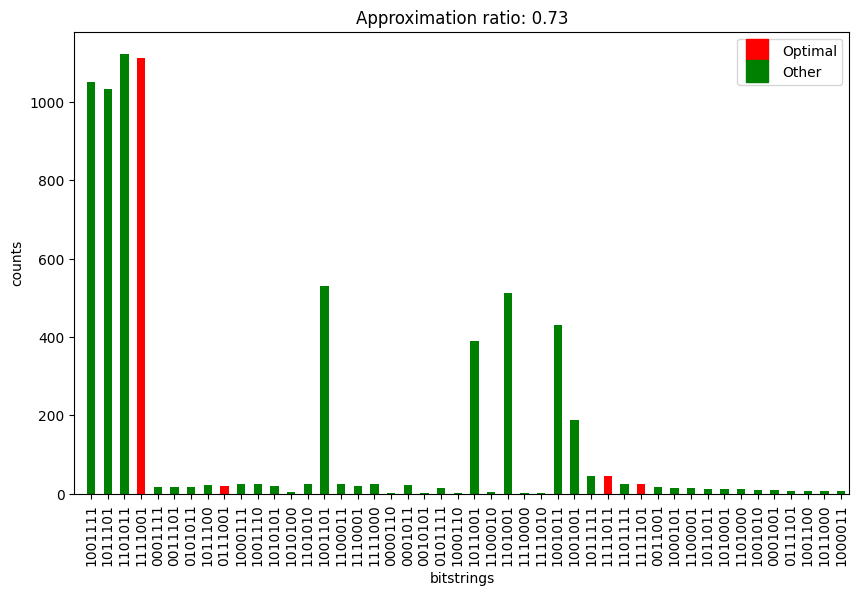

In [ ]:
sol_8q_qaa = run_algorithm(seq_qaa)

fig, ax = plt.subplots(figsize=(10, 6))
plot_distribution(sol_8q_qaa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
r = approximation_ratio(sol_8q_qaa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();
#fig.savefig("./Figures/r_qaa_q8.png", bbox_inches="tight")

**The results of QAOA and QAA successfully identified the optimal bitstring 1111001, which corresponds to the complete reaction pathway from CO₂ to methanol. This bitstring represents the selection of the following chemical species: CO₂ (0), HCOO (1), HCO (2), CH₃O (3), and CH₃OH (6, the desired product). This solution achieved the lowest cost value of -113.37 and was found with high frequency (1112 counts), indicating strong algorithmic convergence.
Our quantum algorithm results demonstrate a clear preference for this pathway, which forms a complete reaction sequence without any interruptions in the chemical transformation steps. The optimal nature of this solution is further validated by comparison with sub-optimal alternatives. For instance, bitstring 1101011 (cost: -65.17, count: 1123) includes the undesired CH₄ byproduct while missing the crucial HCO intermediate. Similarly, bitstring 1001111 (cost: -22.83, count: 1050) contains both CO and CH₄ byproducts while lacking the essential HCOO and HCO intermediates.
The brute force verification confirms that 1111001 indeed represents the global optimum for this reaction pathway optimization problem, validating the effectiveness of our quantum approach in identifying the most energetically favorable and chemically coherent route for methanol synthesis from carbon dioxide.**